# Procedure for image preprocessing

## Setup

In [1]:
# %load_ext nb_black
# %matplotlib notebook
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
from PIL import ImageStat
import random
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ.get("TRAINING_DIRECTORY_PROD")


'F:/big-data/uni/minor-a-systems/cucumber-dataset-production-line'

## Define constants and read the data

In [3]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get("TRAINING_DIRECTORY_PROD")

# Define the image size
img_height = 1436
img_width = 3034


In [4]:
# Read in the images and resize them
classes = ["healthy", "infected"]
images = []
labels = []
img_paths = []
img_dir = f"{train_dir}/healthy"
for idx, img_file in enumerate(os.listdir(img_dir)):
    if (idx % 6) != 1:
        continue
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(0)
    img_paths.append(path)

img_dir = f"{train_dir}/infected"
for idx, img_file in enumerate(os.listdir(img_dir)):
    if (idx % 6) != 1:
        continue
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(1)
    img_paths.append(path)

# Convert the data and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
img_paths = np.array(img_paths)

In [5]:
images.shape

(188, 1436, 3034, 3)

## Store some information about the dataset into a Dataframe

- The cucumber image is masked (where the BLUE channel is below some threshold to filter out the background)
- The first row is found where the mask contains at least 1/64 true values (sorting out possible single pixels that were not filtered out)
    - This is considered the start y-pixel-coordinate of the cucumber
- From there search the first row where there are less than 1/64 true values
    - This is considered the end y-pixel-coordinate of the cucumber 
- Same process is repeated for columns to get the x-pixel-coordinates


In [6]:
# Crop images to the conveyor belt size
start_x, start_y, end_x, end_y = 500, 255, 2520, 905

new_images = []

for (index, image) in enumerate(images):

    # Crop images to both sides
    image = image[
        start_y: end_y,
        start_x: end_x,
    ]
    new_images.append(image)

images = np.array(new_images)
images.shape

(188, 650, 2020, 3)

In [7]:
# # Map all images to their blue channel and flatten them
# images_blue_flattened = []
# for image in images:
#     images_blue_flattened.append(images[0][:, :, 2].ravel())
# images_blue_flattened = np.array(images_blue_flattened)
# print(f'Shape: {images_blue_flattened.shape}')

# # -- Plot the average number of blue pixels per image --
# mean = np.median(images_blue_flattened, axis=0)
# plt.hist(mean, bins=int(255/5))

# # -- Use the histogram to find the threshold for masking the background --

In [8]:

def get_first_and_last_cucumber_pixel(image):
    # masked_img = image[..., 2] < MASK_BLUE_THRESHOLD

    (_, masked_img) = cv2.threshold(
        image[..., 2], 5, 1, cv2.THRESH_BINARY)

    first_cucumber_pixel_y = None
    last_cucumber_pixel_y = None
    threshold_height = img_height / 64
    for i in range(masked_img.shape[0]):
        if np.sum(masked_img[i, :]) > threshold_height:
            first_cucumber_pixel_y = i
            j = first_cucumber_pixel_y
            for j in range(i, masked_img.shape[0]):
                last_cucumber_pixel_y = j
                if np.sum(masked_img[j, :]) <= threshold_height:
                    break
            break

    first_cucumber_pixel_x = None
    last_cucumber_pixel_x = None
    threshold_width = 2
    threshold_min_width = img_width / 16
    for i in range(masked_img.shape[1]):
        if np.sum(masked_img[:, i]) > threshold_width:
            first_cucumber_pixel_x = i
            for j in range(first_cucumber_pixel_x, masked_img.shape[1]):
                last_cucumber_pixel_x = j
                if np.sum(masked_img[:, j]) <= threshold_width and j - first_cucumber_pixel_x > threshold_min_width:
                    break
            break

    return (
        (first_cucumber_pixel_x, first_cucumber_pixel_y),
        (last_cucumber_pixel_x, last_cucumber_pixel_y),
    )

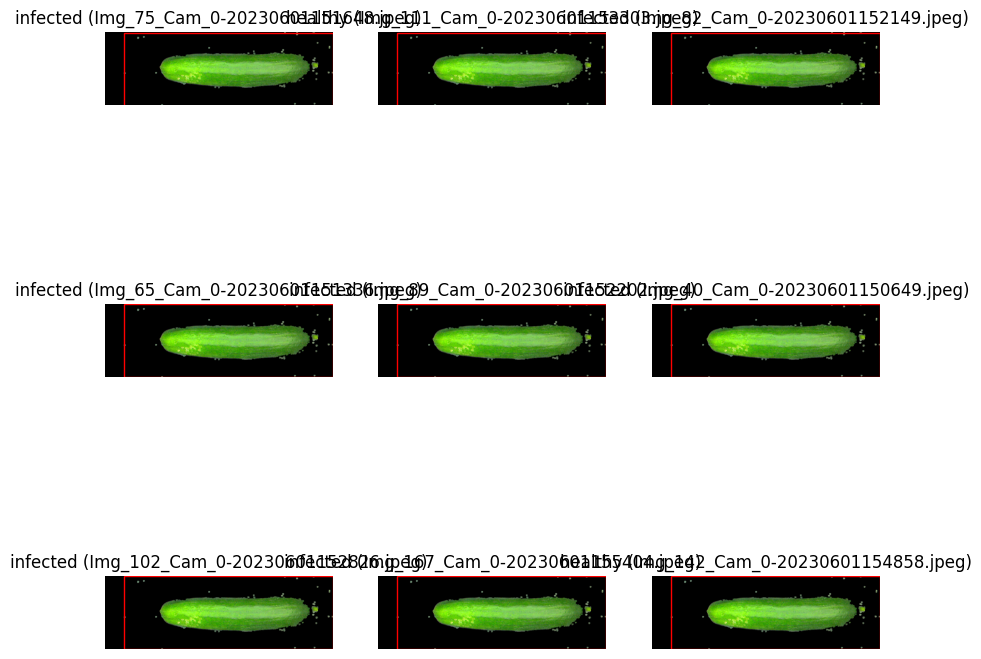

In [9]:
def mask_cucumber(img):
    # Convert the image to the HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for the green color in HSV
    # Adjust these values to fit your specific shade of green
    lower_green = np.array([40, 60, 100])
    # Adjust these values to fit your specific shade of green
    upper_green = np.array([70, 255, 255])
    # lower_green = np.array([.1/255 * 23, .1/255 * 20,.1/255 * 14])
    # upper_green = np.array([.1/255 * 142, 255, 255])

    # Create a mask for the green pixels within the specified range
    mask = cv2.inRange(hsv_img, lower_green, upper_green)

    # Apply image morphology operations to enhance the blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    sure_bg = cv2.dilate(opening, kernel, iterations=2)

    # Perform blob detection on the masked image
    contours, _ = cv2.findContours(
        sure_bg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the bounding coordinates rectangle for the largest blob
    first_x, first_y, last_x, last_y = 99999, 99999, 0, 0
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        first_x = min(first_x, x)
        first_y = min(first_y, y)
        last_x = max(last_x, x + w)
        last_y = max(last_y, y + h)

    # Create a blank mask image
    mask_image = np.zeros_like(img)

    # Draw filled contours on the mask image
    cv2.drawContours(mask_image, contours, -1,
                     (255, 255, 255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img, mask_image)

    return (masked_img, (first_x, first_y, last_x, last_y))


plt.figure(figsize=(10, 10))
for i in range(9):
    rand_idx = random.randint(0, images.shape[0] - 1)
    ax = plt.subplot(3, 3, i + 1)
    masked_image, (first_x, first_y, last_x, last_y) = mask_cucumber(image)

    rect = patches.Rectangle(
        (
            first_x, first_y
        ),
        last_x - first_x,
        last_y - first_y,
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)

    plt.imshow(masked_image)
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f"{classes[labels[rand_idx]]} ({path})")
    plt.axis("off")


In [10]:
# Apply the mask cucumber function to each image in the numpy images array
masked_images = []
df_records = []

for image in images:
    masked_image, (first_x, first_y, last_x, last_y) = mask_cucumber(image)
    masked_images.append(masked_image)
    df_records.append({
        "idx": i,
        "label": classes[labels[i]],
        'first_x': first_x,
        'first_y': first_y,
        'last_x': last_x,
        'last_y': last_y,
        "cucumber_height": last_y - first_y,
        "cucumber_width": last_x - first_x,
    })

# Convert the masked images to a numpy array
images = np.array(masked_images)
df = pd.DataFrame(df_records)

print(df)


     idx    label  first_x  first_y  last_x  last_y  cucumber_height  \
0      8  healthy       43        6    2020     650              644   
1      8  healthy       51        3    2020     647              644   
2      8  healthy      196        0    2015     650              650   
3      8  healthy      282        0    2020     650              650   
4      8  healthy      297        0    2020     650              650   
..   ...      ...      ...      ...     ...     ...              ...   
183    8  healthy      115        0    2020     650              650   
184    8  healthy       37       18    2020     650              632   
185    8  healthy      109        0    2020     650              650   
186    8  healthy      184        0    2020     530              530   
187    8  healthy      167        3    2020     650              647   

     cucumber_width  
0              1977  
1              1969  
2              1819  
3              1738  
4              1723  
.. 

In [11]:
# Crop the image to the cucumber tip
image_size = int(img_width / 4)
img_size_final = 512
def crop_cucumber_tip(img, first_x, first_y, last_x, last_y):
    # Append black pixels in the y direction of the image
    img = np.concatenate(
        (
            img,
            np.zeros((img_width - img_height, img.shape[1], 3)).astype(np.uint8),
        ),
        axis=0,
    )

    # # Crop the image
    # img = img[first_y: first_y + image_size,
    #           first_x: first_x + image_size]
    
    img = cv2.resize(src=img, dsize=(img_size_final, img_size_final),
                       interpolation=cv2.INTER_CUBIC)

    return img


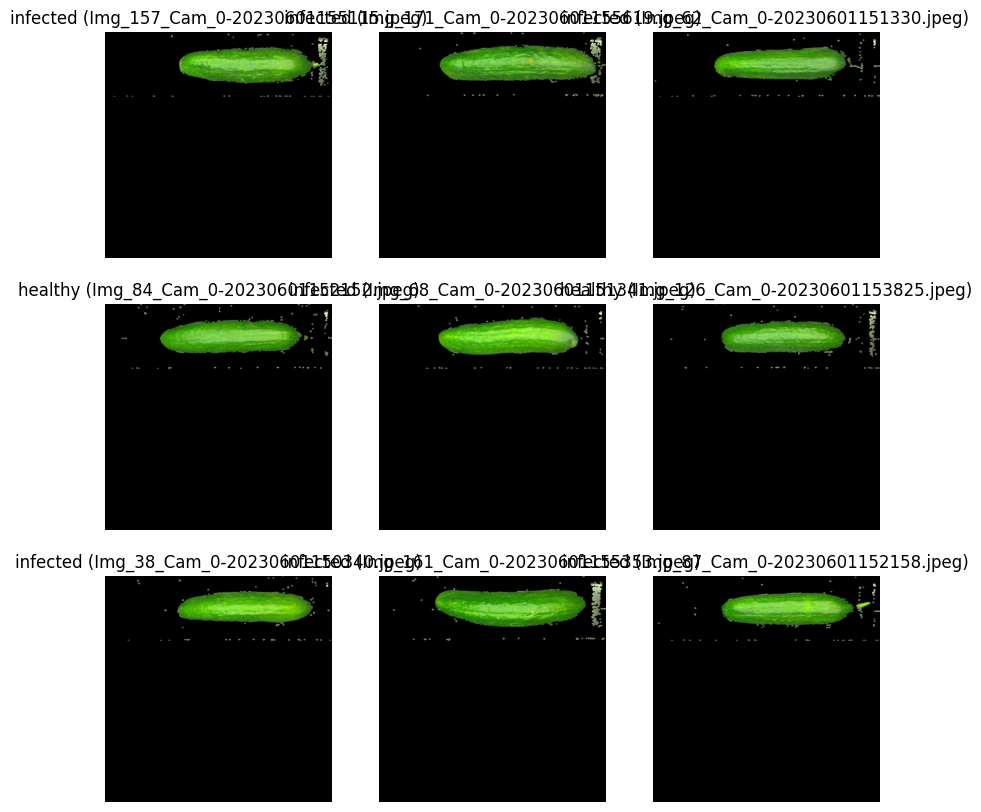

In [12]:
# Use the crop cucumber function to display 9 sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    rand_idx = random.randint(0, images.shape[0] - 1)
    ax = plt.subplot(3, 3, i + 1)

    img = images[rand_idx]
    img = crop_cucumber_tip(img, df.iloc[rand_idx]["first_x"], df.iloc[rand_idx]
                            ["first_y"], df.iloc[rand_idx]["last_x"], df.iloc[rand_idx]["last_y"])

    plt.imshow(img)
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f"{classes[labels[rand_idx]]} ({path})")
    plt.axis("off")


In [13]:
final_data = []
for (idx, image) in enumerate(images):
    image = crop_cucumber_tip(image, df.iloc[idx]["first_x"], df.iloc[idx]
                              ["first_y"], df.iloc[idx]["last_x"], df.iloc[idx]["last_y"])
    final_data.append(image)


final_data = np.array(final_data)
final_data.shape


(188, 512, 512, 3)

idx                      8
label              healthy
first_x                284
first_y                  9
last_x                2020
last_y                 650
cucumber_height        641
cucumber_width        1736
Name: 121, dtype: object


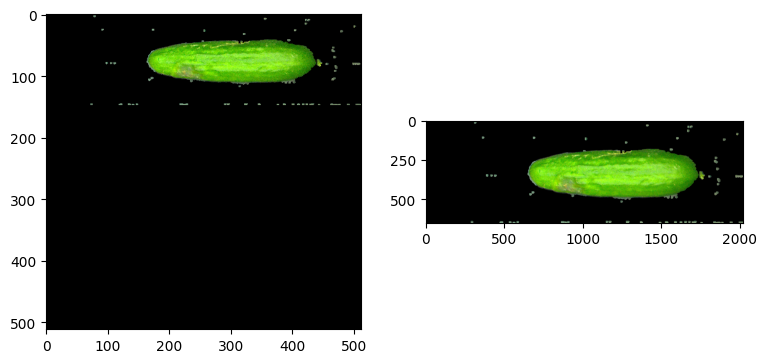

In [14]:
i = random.randint(0, images.shape[0] - 1)

print(df.iloc[i])
plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.imshow(final_data[i])
plt.subplot(2, 2, 2)
plt.imshow(images[i])

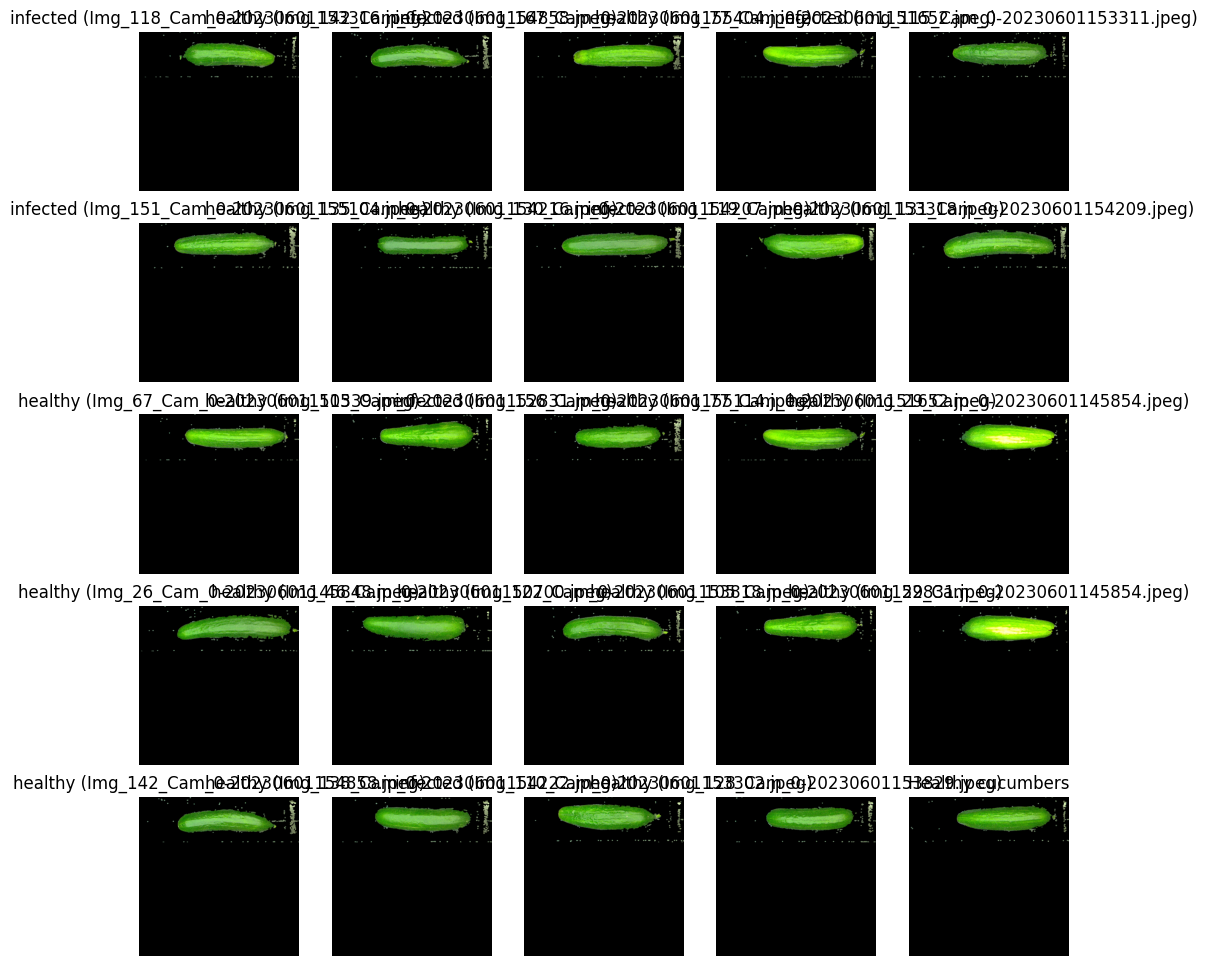

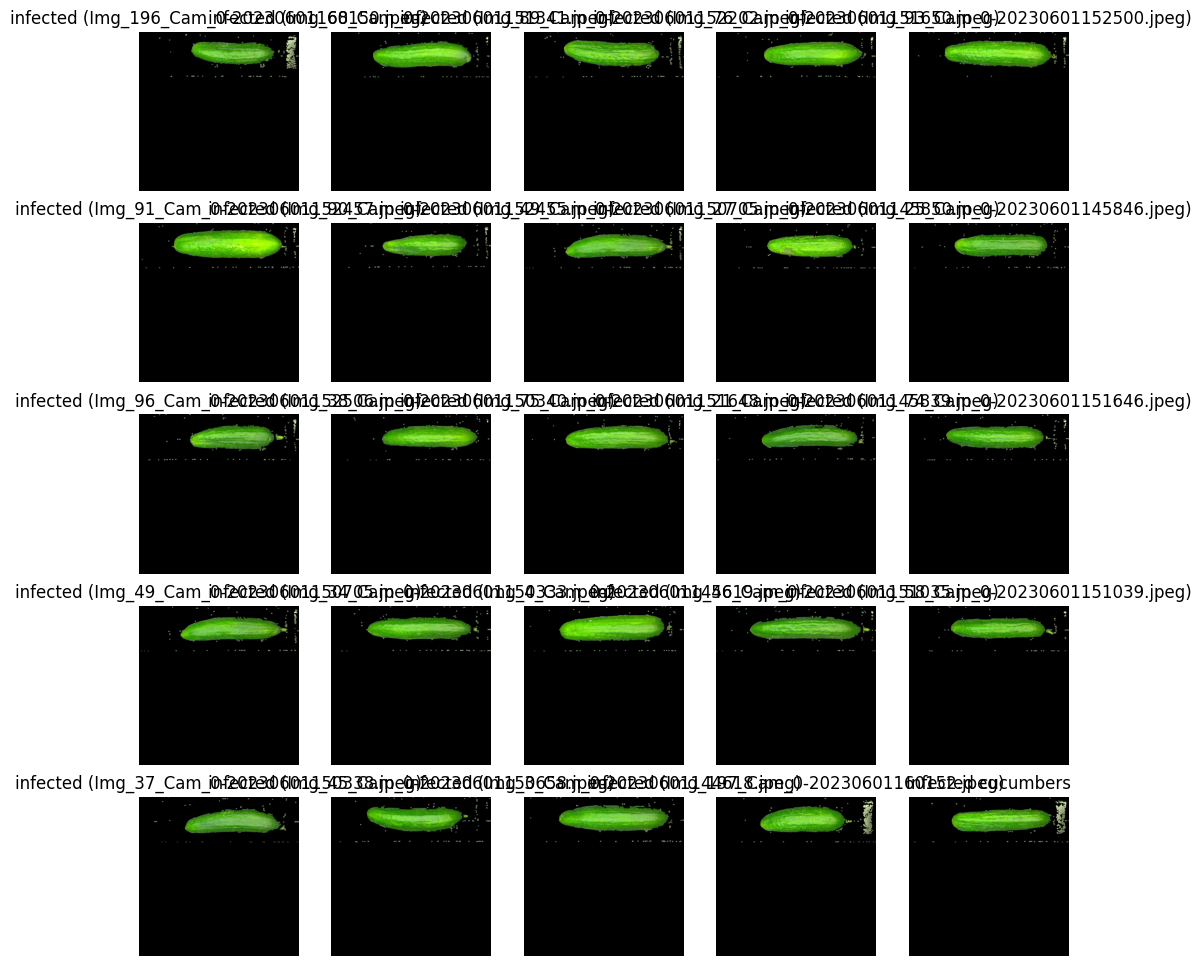

In [15]:
plt.figure(figsize=(12,12))

for i in range(25):
    rand_idx = random.randint(0, int((images.shape[0] / 2)) - 10)
    # rand_idx = rand + i
    # rand_idx = 25 + i
    ax = plt.subplot(5, 5, i + 1)

    plt.imshow(final_data[rand_idx])
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f"{classes[labels[rand_idx]]} ({path})")
    plt.axis("off")
plt.title("Healthy cucumbers")
plt.show()

plt.figure(figsize=(12, 12))

for i in range(25):
    rand_idx = random.randint(int((images.shape[0] / 2))+ 10, (images.shape[0] - 1))
    # rand_idx = rand + i
    # rand_idx = 25 + i
    ax = plt.subplot(5, 5, i + 1)

    plt.imshow(final_data[rand_idx])
    path = img_paths[rand_idx].split(os.sep)[-1]
    plt.title(f"{classes[labels[rand_idx]]} ({path})")
    plt.axis("off")
plt.title("Infected cucumbers")
plt.show()


## AI Training
In the following section the pre_processed images stored in `final_data` are used to train an AI model

In [16]:
# Find the indices of samples with label 0 and label 1
indices_label_healthy = np.where(labels == 0)[0]
indices_label_unhealthy = np.where(labels == 1)[0]

num_healthy = len(indices_label_healthy)
num_unhealthy = len(indices_label_unhealthy)

healthy_images = final_data[indices_label_healthy]
healthy_labels = labels[indices_label_healthy]
unhealthy_images = final_data[indices_label_unhealthy]
unhealthy_labels = labels[indices_label_unhealthy]

wanted_images_per_class = 150

augmentation_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Convert your image array and label array to a generator
image_generator_healthy = augmentation_datagen.flow(
    x=healthy_images,
    y=healthy_labels,
    batch_size=1,
    shuffle=True
)
image_generator_unhealthy = augmentation_datagen.flow(
    x=unhealthy_images,
    y=unhealthy_labels,
    batch_size=1,
    shuffle=True
)

# Create empty arrays to store the augmented images and labels
augmented_images = []
augmented_labels = []

# Generate the augmented images for healthy class and append them to the empty arrays
for i in range(wanted_images_per_class - num_healthy):
    augmented_images.append(image_generator_healthy.next()[0][0])
    augmented_labels.append(0)

# Generate the augmented images for unhealthy class and append them to the empty arrays
for i in range(wanted_images_per_class - num_unhealthy):
    augmented_images.append(image_generator_unhealthy.next()[0][0])
    augmented_labels.append(1)

# Convert the augmented images and labels to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Concatenate the original images/labels with the augmented images/labels
final_data = np.concatenate((final_data, augmented_images))
labels = np.concatenate((labels, augmented_labels))

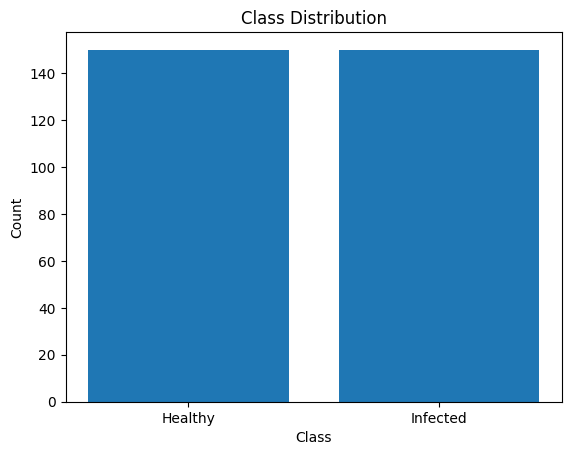

In [17]:
from sklearn.model_selection import train_test_split

counts = np.bincount(labels)

# Create labels for the classes
classes = ['Healthy', 'Infected']

# Plot the bar chart
plt.bar(classes, counts)

# Set the title and labels
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Show the plot
plt.show()

In [18]:
# Save the augmented data and labels to disk
# np.save('data', final_data)
# np.save('labels', labels)


In [19]:
# Split the dataset and normalize the pixel values to be in the range [0, 1]
x_train, x_valid, y_train, y_valid = train_test_split(
    final_data.astype('float32') / 255.0, labels, test_size=0.2, shuffle=True, random_state=187)

print(f'Train: {x_train.shape} | {y_train.shape} Validation: {x_valid.shape} | {y_valid.shape}')


Train: (240, 512, 512, 3) | (240,) Validation: (60, 512, 512, 3) | (60,)


In [20]:
# Model using VGG16 and data segmentation
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

# Load the pre-trained VGG16 model (without the top layer)
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False,
                                       input_shape=input_shape)

# Freeze the weights of the pre-trained layers
for index, layer in enumerate(vgg16_model.layers):
    if len(vgg16_model.layers) - index < 4:
        break
    layer.trainable = False

# Create a new model using the pre-trained VGG16 as a base
model = keras.models.Sequential()
model.add(vgg16_model)

# Add new layers for classification on top of the pre-trained base model
# model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.Recall(),
                       keras.metrics.Precision(),
                       keras.metrics.AUC()])

# Checkpoints for the model
checkpoint = keras.callbacks.ModelCheckpoint(
    "./models_2/best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Create an ImageDataGenerator for data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # horizontal_flip=True
)

# Train the model using data augmentation
history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32),
                    epochs=60, validation_data=train_datagen.flow(x_train, y_train, batch_size=32))
                    # epochs=60, validation_data=train_datagen.flow(x_train, y_train, batch_size=32), callbacks=[checkpoint])


Epoch 1/60
8/8 [==============================] - 36s 2s/step - loss: 2.1272 - accuracy: 0.6250 - recall: 0.5385 - precision: 0.6364 - auc: 0.6244 - val_loss: 0.5879 - val_accuracy: 0.7667 - val_recall: 0.7949 - val_precision: 0.7440 - val_auc: 0.8581
Epoch 2/60
8/8 [==============================] - 7s 879ms/step - loss: 0.5689 - accuracy: 0.7042 - recall: 0.7521 - precision: 0.6769 - auc: 0.7707 - val_loss: 0.4857 - val_accuracy: 0.7833 - val_recall: 0.9658 - val_precision: 0.7019 - val_auc: 0.8688
Epoch 3/60
8/8 [==============================] - 7s 877ms/step - loss: 0.4581 - accuracy: 0.8042 - recall: 0.9487 - precision: 0.7303 - auc: 0.8576 - val_loss: 0.4734 - val_accuracy: 0.7583 - val_recall: 0.6667 - val_precision: 0.8041 - val_auc: 0.8766
Epoch 4/60
8/8 [==============================] - 7s 886ms/step - loss: 0.4527 - accuracy: 0.7667 - recall: 0.8034 - precision: 0.7402 - auc: 0.8495 - val_loss: 0.4109 - val_accuracy: 0.8042 - val_recall: 0.9402 - val_precision: 0.7333 - va

In [21]:
import pickle


# Persist the model
model.save('./models_3/cucumber_model_main.h5')

# Save the history object to a file
with open('./models_3/cucumber_model_main_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [22]:
# Load model and history
# import pickle

# model.load_weights("./models_2/cucumber_model_main.h5")

# # Load the history object from the file
# with open('./models_2/cucumber_model_main_history.pkl', 'rb') as file:
#     history = pickle.load(file)


[0, 0, 0.4581499397754669, 0.45269307494163513, 0.430916428565979, 0.40465983748435974, 0.3877263069152832, 0.4069426655769348, 0.37773069739341736, 0.3291299641132355, 0.2845345437526703, 0.2472049444913864, 0.1948769986629486, 0.15424345433712006, 0.12201794981956482, 0.09801151603460312, 0.06442006677389145, 0.04195262864232063, 0.031787339597940445, 0.023897958919405937, 0.019047323614358902, 0.00858325231820345, 0.009846407920122147, 0.004804274998605251, 0.003676053136587143, 0.0029240469448268414, 0.0021741758100688457, 0.001994798891246319, 0.001566171064041555, 0.0012593569699674845, 0.0010691715870052576, 0.001013648696243763, 0.000870505056809634, 0.0008561602444387972, 0.0007606531726196408, 0.0007025701343081892, 0.0006700169178657234, 0.0006147256935946643, 0.0005771337891928852, 0.0005463653360493481, 0.0005214248667471111, 0.0004870006814599037, 0.00047075210022740066, 0.00044154617353342474, 0.0004239096597302705, 0.000404307444114238, 0.00038076663622632623, 0.0003731

C:\Users\nikla\AppData\Local\Temp\ipykernel_11616\3079028268.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


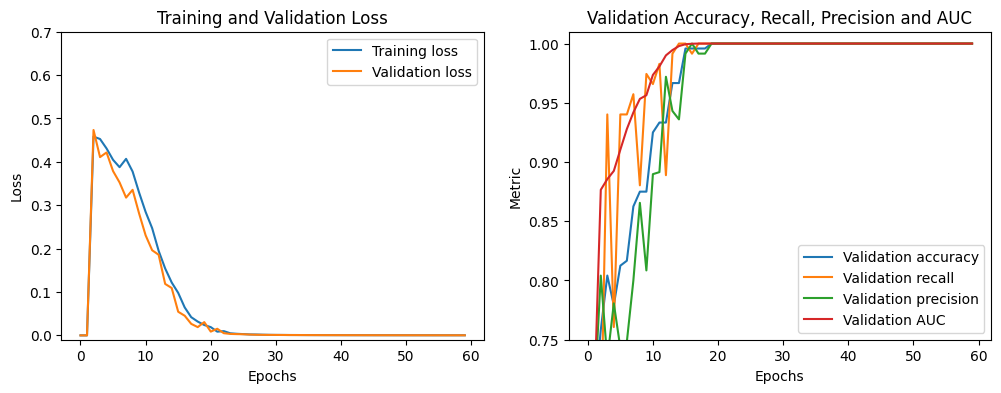

In [27]:
# Plot the training and validation loss graphs
plot_start_epoch = 2


train_loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall']
val_precision = history.history['val_precision']
val_auc = history.history['val_auc']

train_loss[:plot_start_epoch] = [0] * plot_start_epoch
val_loss[:plot_start_epoch] = [0] * plot_start_epoch
val_acc[:plot_start_epoch] = [0.7] * plot_start_epoch
val_recall[:plot_start_epoch] = [0.7] * plot_start_epoch
val_precision[:plot_start_epoch] = [0.7] * plot_start_epoch
val_auc[:plot_start_epoch] = [0.7] * plot_start_epoch

plt.subplots(figsize=(12, 4))

# SUbplot 0
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim([-0.01, 0.7])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# SUbplot 1
plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Validation accuracy')
plt.plot(val_recall, label='Validation recall')
plt.plot(val_precision, label='Validation precision')
plt.plot(val_auc, label='Validation AUC')
plt.ylim([0.75, 1.01])
plt.title('Validation Accuracy, Recall, Precision and AUC')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()


plt.show()


In [24]:
# assume you have a trained keras model that performs binary classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = model.predict(x_valid)  # predict probabilities



2/2 [==============================] - 22s 21s/step


[[22  5]
 [ 1 32]]


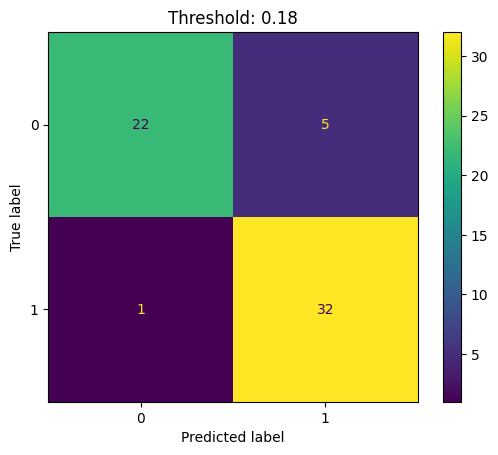

In [25]:
# set a threshold for binary classification
threshold = 0.18

# convert probabilities to binary labels based on the threshold
predictions_labeled = (predictions > threshold).astype('int')

# assume binary_predictions is the binary label array
predicted_labels = np.where(predictions_labeled == 1, 'infected', 'healthy')

cm = confusion_matrix(y_valid, predictions_labeled)
# Print the confusion matrix
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Threshold: {threshold}')
plt.show()


In [46]:
import time

rounds = 20
start_time = time.time()

img_dir = f"{train_dir}/infected"
one_img_vec = []
for i in range(rounds):
    for idx, img_file in enumerate(os.listdir(img_dir)):
        if (idx % 6) != 1:
            continue
        path = os.path.join(img_dir, img_file)
        img = tf.keras.preprocessing.image.load_img(
            path, target_size=(img_height, img_width)
        )
        img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)


        img, (first_x, first_y, last_x, last_y) = mask_cucumber(image)

        img = crop_cucumber_tip(img, first_x, first_y, last_x, last_y)

        one_img_vec = np.array([img])
        break


runtime_pre = time.time() - start_time

print('Runtime (preprocessing):', runtime_pre / 100, 'seconds')

# ----

test_img = np.array([x_valid[0]])
# Record the start time
start_time = time.time()

test_img = np.array([x_valid[0]])
# Run the code snippet
for i in range(rounds):
    predictions = model.predict(test_img)  # predict probabilities
    

# Calculate the runtime
runtime_pred = time.time() - start_time

# Print the runtime
print('Runtime (predictions):', runtime_pred / rounds, 'seconds')

print('Runtime (all):', (runtime_pred / rounds) + (runtime_pre / rounds), 'seconds')


Runtime (preprocessing): 0.007076916694641114 seconds
1/1 [==============================] - 0s 22ms/step
Runtime (predictions): 0.09363923072814942 seconds
Runtime (predictions): 0.129023814201355 seconds
